# Niwot Scatter Plots
* trying to look at the full unloading vs some unloading 
* scatter plots with wind thresholded, to see temp and sw relationship without wind

## Import packages 

In [2]:
# import packages 
%matplotlib widget
# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

# interactive plotting
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

In [3]:
import seaborn as sns # a module that adds some plotting capabilities and makes your plots look better
import matplotlib as mpl
sns.set() # activates some of the default settings from seaborn
# The following settings just set some defaults for the plots
plt.rcParams['figure.figsize']  = (12,4) #width, height
plt.rcParams['axes.titlesize']  = 14
plt.rcParams['axes.labelsize']  = 12
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 11
mpl.rcParams['figure.dpi'] = 100

sns.set_style("dark", {"xtick.bottom": True, 'ytick.left': True})

## Load and Clean datasets for use

In [4]:
# AMERIFLUX MET DATA 
niwotflux =   pd.read_csv("/Users/Lumbr/OneDrive - UW/Documents/Washington/UnloadingRegimes/OtherSites/niwot_2017_ameriflux_unload1hr.csv")
niwotflux['datetime']  = pd.DatetimeIndex(niwotflux['datetime'])

# OBSERVATIONS CLASSIFICATIONS
niwotobs =  pd.read_csv("/Users/Lumbr/OneDrive - UW/Documents/Washington/UnloadingRegimes/OtherSites/Classifications/datetimeformat_classifications_niwot2017_type.csv")
niwotobs['datetime'] = pd.to_datetime(niwotobs['datetime'])

niwotobs.dropna(axis=0, how='all', inplace=True) #removing row is entire row is NAN #careful with this, without datetime a lot gets removed 

# MERG THEM 
niwotdf = pd.merge(niwotflux, niwotobs, how='outer', on='datetime')
niwotdf.index = pd.DatetimeIndex(niwotdf['datetime'])

#### Making "type" a symbol too
**Type**
* type 1 = some unloading from the event 
* type 2 = all unloaded from the event

**Snow**
* snow sub: sublimation
* snow mass: mass unloading
* snow melt: melt unloading

In [5]:
# https://plotly.com/python/marker-style
# SUNLIT-------------------------------------------------------
# Create symbols for sunlit or not
niwotdf['Esymbol'] = np.nan

# open triangle for cloudy, diamond for sunny, open x circle for no radiation data
niwotdf['Esymbol'].mask(niwotdf['E'] == 0., 105, inplace=True)
niwotdf['Esymbol'].mask(niwotdf['E'] == 1., 2, inplace=True)    

# then fillna with 128 for circle with x through it 
niwotdf['Esymbol'] = niwotdf['Esymbol'].fillna(128) 

# TYPE-------------------------------------------------------
# Create symbols for type 1 and type 2 
niwotdf['Typesymbol'] = np.nan

# open diamont for type 1, diamond for type 2, open x circle for no classification
niwotdf['Typesymbol'].mask(niwotdf['Type'] == 1, 102, inplace=True) 
niwotdf['Typesymbol'].mask(niwotdf['Type'] == 2., 2, inplace=True)    

# then fillna with 128 for circle with x through it 
niwotdf['Typesymbol'] = niwotdf['Typesymbol'].fillna(128)  

# SNOW-------------------------------------------------------
# Create symbols for sunlit or not
niwotdf['Snowsymbol'] = np.nan

# niwotdf['Snowsymbol'].mask(niwotdf['Snow'] == 'mass', 105, inplace=True) # this is working without fillna
niwotdf['Snowsymbol'].mask(niwotdf['Snow'] == 'sub', 17, inplace=True)  # Full Star
# niwotdf['Snowsymbol'].mask(niwotdf['Snow'] == 'melt', 2, inplace=True)    

# then fillna with 128 for circle with x through it 
niwotdf['Snowsymbol'] = niwotdf['Snowsymbol'].fillna(100)  # empty circle

#_________________________________________________________

# Create seperate df for only snow in the canopy timesteps 
df_unload = niwotdf.copy(deep=True)
df_unload = df_unload.dropna(axis=0, subset=['CD'])

# Have to remove all nans for this plotting to work.... need to come back to this 
# df_unload.dropna(inplace=True) #########KEEP THIS IN MIND, COME BACK TO IT

# Create sunlit column
df_unload['Sunlit'] = df_unload.E.copy(deep=True)
df_unload.Sunlit.mask(df_unload.Sunlit == 0, "Not Sunlit", inplace=True)
df_unload.Sunlit.mask(df_unload.Sunlit == 1, "Sunlit Canopy", inplace=True)

# Create unloading classification column
df_unload['Classification'] = df_unload.CD.copy(deep=True)
df_unload.Classification.mask(df_unload.Classification == 0, "Snow Unloading", inplace=True)
df_unload.Classification.mask(df_unload.Classification == 1, "Snow Staying in the Canopy", inplace=True)

snowstaydf   = df_unload.where(df_unload.CD == 1).dropna(axis=0, subset=['CD']) # where CD == 1, meaning Snow Staying, make that snowstaydf
snowunloaddf = df_unload.where(df_unload.CD == 0).dropna(axis=0, subset=['CD']) # where CD == 0, meaning Snow Unloading, make that snowunloaddf

# Plotting

In [6]:
## Define some plotting constants for easier coding 
plt.close('all')

# Colors
colornosnow='lightgrey' # the plotly no snow color so that it is lightly and not dominate in the plot 
colorsnow = '#7dcfd4' # slightly desaturated cyan
colorsnowunload = '#1F15D5' # bright, deep blue 
colorsunny = '#E4E44A' # trying a little less bright 

# Grouped Colors
colors = [colorsnow, colorsnowunload] # my colors 

# Names
namesnow = 'Snow Staying'
namesnowunload = 'Snow Unloading'
group_labels = ['Snow Staying', 'Snow Unloading']

nametemp = "Air Temperature (C)"
nameSW = "Shortwave (W/m2)"
namewind = "Wind Speed (m/s)"

# Hist defaults
bintemp = [2,2]
binSW = [100,100]
binwind = [1,1]

## Make thresholded datasets

In [7]:
# Create copies of the df we want, and then going to classify it by SW threshold
dfSW600 =    df_unload.copy(deep=True) # SW > 600
dfSW400600 = df_unload.copy(deep=True) # SW between 400-600
dfSW400 =    df_unload.copy(deep=True) # SW < 400

# Create for temperature threshold 
dfTg0 =    df_unload.copy(deep=True) # Temp g(greater) 0
dfTl0 =    df_unload.copy(deep=True) # Temp l(less)    0 

# Creating df with only SW > 600
dfSW600.mask(dfSW600.shortwave < 600, inplace=True) # we want where SW > 600, else nan
dfSW600.dropna(inplace=True) # and drop all nan... 
dfSW600stay   = dfSW600.where(dfSW600.CD == 1).dropna()
dfSW600unload = dfSW600.where(dfSW600.CD == 0).dropna()

# Creating df with onyl 400 < SW < 600
dfSW400600.mask(dfSW400600.shortwave > 600, inplace=True) # we want where SW < 600, 
dfSW400600.mask(dfSW400600.shortwave < 400, inplace=True) # and SW > 400, else nan
dfSW400600.dropna(inplace=True) # and drop all nan... 
dfSW400600stay   = dfSW400600.where(dfSW400600.CD == 1).dropna()
dfSW400600unload = dfSW400600.where(dfSW400600.CD == 0).dropna()

# Creating df with SW < 400
dfSW400.mask(dfSW400.shortwave > 400, inplace=True) # we want where SW < 400, else nan
dfSW400.dropna(inplace=True) # and drop all nan...
dfSW400stay   = dfSW400.where(dfSW400.CD == 1).dropna()
dfSW400unload = dfSW400.where(dfSW400.CD == 0).dropna()

# Create df with T > 0 
dfTg0.mask(dfTg0.temp < 0, inplace=True) # we want where T > 0, else nan
dfTg0.dropna(inplace=True) 
dfTg0stay   = dfTg0.where(dfTg0.CD == 1).dropna()
dfTg0unload = dfTg0.where(dfTg0.CD == 0).dropna()

# Create df with T < 0 
dfTl0.mask(dfTl0.temp > 0, inplace=True) # we want where T < 0, else nan 
dfTl0.dropna(inplace=True)
dfTl0stay   = dfTl0.where(dfTl0.CD == 1).dropna()
dfTl0unload = dfTl0.where(dfTl0.CD == 0).dropna()

# Create for wind threshold 
niwot_dfWg5  =   df_unload.copy(deep=True) # Wind g(greater) 5
niwot_dfWl5 =   df_unload.copy(deep=True) # Wind l(less)    5

# Create df with W > 5 
niwot_dfWg5.mask(niwot_dfWg5.windspeed < 5, inplace=True) # we want where T > 0, else nan
niwot_dfWg5.dropna(axis=0, subset=['windspeed'], inplace=True) 
niwot_dfWg5stay   = niwot_dfWg5.where(niwot_dfWg5.CD == 1).dropna(axis=0, subset=['CD'])
niwot_dfWg5unload = niwot_dfWg5.where(niwot_dfWg5.CD == 0).dropna(axis=0, subset=['CD'])

# Create df with W < 5 
niwot_dfWl5.mask(niwot_dfWl5.windspeed >= 5, inplace=True) # we want where T < 0, else nan 
niwot_dfWl5.dropna(axis=0, subset=['windspeed'], inplace=True)
niwot_dfWl5stay   = niwot_dfWl5.where(niwot_dfWl5.CD == 1).dropna(axis=0, subset=['CD'])
niwot_dfWl5unload = niwot_dfWl5.where(niwot_dfWl5.CD == 0).dropna(axis=0, subset=['CD'])

# Scatter Plots: for partial unloading

In [10]:
# State which site we are working with 
df = df_unload.copy(deep=True)

# Some constatns 
colorscaled = [[0., colorsnowunload], [1, colorsnow]]
index_vals = df['CD']
index_symbols = df['Typesymbol']

fig = go.Figure()
fig.add_trace(go.Splom(dimensions=[dict(label='Air Temperature (C)',     values=df['temp']),
                                   dict(label='Wind Speed (m/s)', values=df['windspeed']),
                                   dict(label='Shortwave (W/m2)', values=df['shortwave'])],
                                   marker=dict(color=index_vals, colorscale=colorscaled, symbol=index_symbols, showscale=False, line_color='black', line_width=0.5, size=7),
                                   showlegend=False, showupperhalf=False, diagonal_visible=False,
                      ))

# Other options
#showupperhalf=False, diagonal_visible=False
#marker=dict(show scale=False)

# fig.update_traces(showlegend=True, legendgroup=index_symbols, selector=dict(mode='spolm'))
# fig.update_traces(showlegend=True)

fig.update_layout(title='Niwot Ridge, Colorado, USA', width=800, height=700, dragmode='select')

fig.show()

## Looking at Shapped by Sublimation Obs 

In [8]:
df_sub = df_unload.copy(deep=True)

# TYPE-------------------------------------------------------
# Create symbols for type 1 and type 2 
df_sub['Typesymbol'] = np.nan

# open diamont for type 1, diamond for type 2, open x circle for no classification
df_sub['Typesymbol'].mask(df_sub['Type'] == 1, 102, inplace=True) 
df_sub['Typesymbol'].mask(df_sub['Type'] == 2., 2, inplace=True)    

# then fillna with 128 for circle with x through it 
df_sub['Typesymbol'] = df_sub['Typesymbol'].fillna(128)  

# Class-------------------------------------------------------
# Create symbols for sunlit or not
df_sub['Classsymbol'] = np.nan

df_sub['Classsymbol'].mask(df_sub['Class'] == 'wind', 17, inplace=True)  # Full Star
df_sub['Classsymbol'].mask(df_sub['Class'] == 'tempwind', 17, inplace=True)  # Full Star
df_sub['Classsymbol'].mask(df_sub['Class'] == 'swwind', 17, inplace=True)  # Full Star
df_sub['Classsymbol'].mask(df_sub['Class'] == 'tempswwind', 17, inplace=True)  # Full Star


# then fillna with 128 for circle with x through it 
df_sub['Classsymbol'] = df_sub['Classsymbol'].fillna(128)  # empty circle


# SNOW-------------------------------------------------------
# Create symbols for sunlit or not
df_sub['Snowsymbol'] = np.nan

# niwotdf['Snowsymbol'].mask(niwotdf['Snow'] == 'mass', 105, inplace=True) # this is working without fillna
df_sub['Snowsymbol'].mask(df_sub['Snow'] == 'sub', 17, inplace=True)  # Full Star
# niwotdf['Snowsymbol'].mask(niwotdf['Snow'] == 'melt', 2, inplace=True)    

# then fillna with 128 for circle with x through it 
df_sub['Snowsymbol'] = df_sub['Snowsymbol'].fillna(128)  # empty circle

In [9]:
# State which site we are working with 
# df = df_unload.copy(deep=True)
df = df_sub.copy(deep=True)


# Some constatns 
colorscaled = [[0., colorsnowunload], [1, colorsnow]]
index_vals = df['CD']
index_symbols = df['Snowsymbol']

fig = go.Figure()
fig.add_trace(go.Splom(dimensions=[dict(label=nametemp, values=df['temp']),
                                   dict(label=namewind, values=df['windspeed']),
                                   dict(label=nameSW,   values=df['shortwave'])],
                                   marker=dict(color=index_vals, colorscale=colorscaled, symbol=index_symbols, showscale=False, line_color='black', line_width=0.5, size=7),
                                   showlegend=False, showupperhalf=False, diagonal_visible=False,
                      ))

# Other options
#showupperhalf=False, diagonal_visible=False
#marker=dict(show scale=False)

# fig.update_traces(showlegend=True, legendgroup=index_symbols, selector=dict(mode='spolm'))
# fig.update_traces(showlegend=True)

fig.update_layout(title='Niwot Ridge, Colorado, USA: star = sublimation', width=800, height=700, dragmode='select')

fig.show()

In [10]:
# State which site we are working with 
# df = df_unload.copy(deep=True)
df = df_sub.copy(deep=True)


# Some constatns 
colorscaled = [[0., colorsnowunload], [1, colorsnow]]
index_vals = df['CD']
index_symbols = df['Classsymbol']

fig = go.Figure()
fig.add_trace(go.Splom(dimensions=[dict(label=nametemp, values=df['temp']),
                                   dict(label=namewind, values=df['windspeed']),
                                   dict(label=nameSW,   values=df['shortwave'])],
                                   marker=dict(color=index_vals, colorscale=colorscaled, symbol=index_symbols, showscale=False, line_color='black', line_width=0.5, size=7),
                                   showlegend=False, showupperhalf=False, diagonal_visible=False,
                      ))

# Other options
#showupperhalf=False, diagonal_visible=False
#marker=dict(show scale=False)

# fig.update_traces(showlegend=True, legendgroup=index_symbols, selector=dict(mode='spolm'))
# fig.update_traces(showlegend=True)

fig.update_layout(title='Niwot Ridge, Colorado, USA: star = wind', width=800, height=700, dragmode='select')

fig.show()

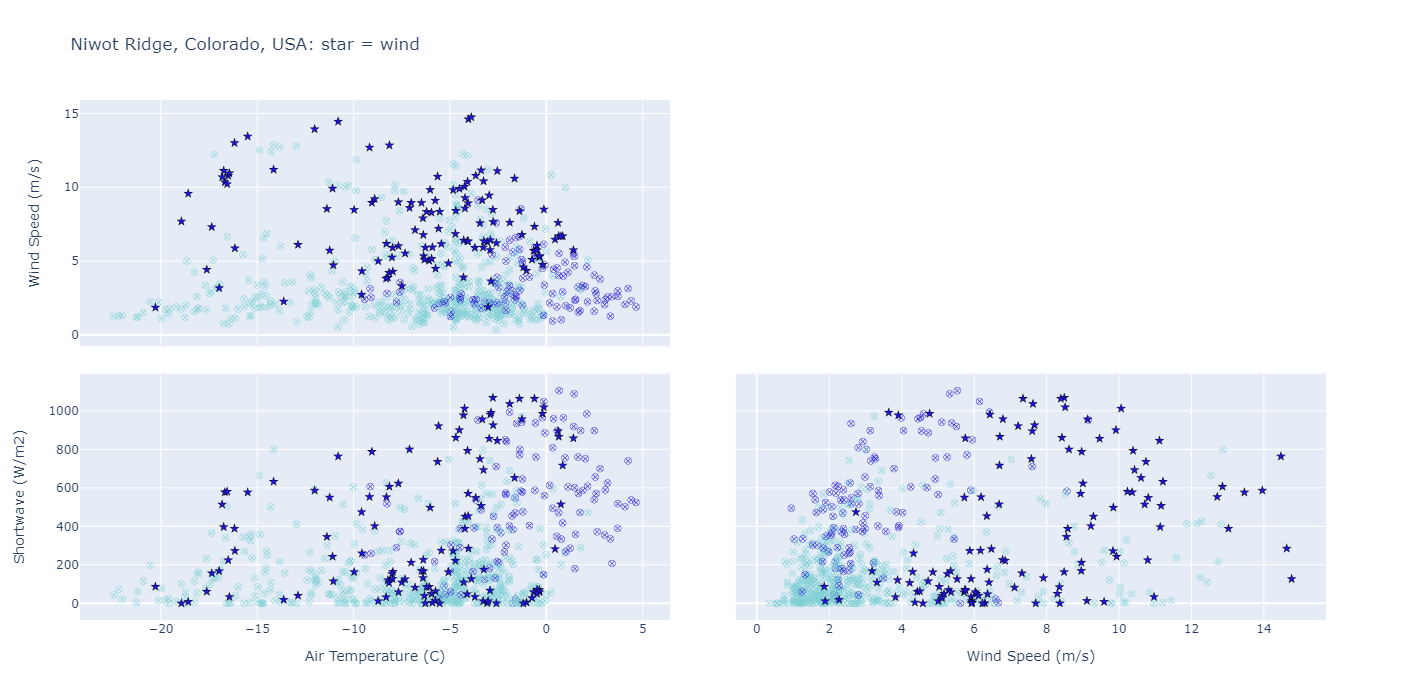

In [100]:
# State which site we are working with 
# df = df_unload.copy(deep=True)
df = df_sub.copy(deep=True)


# Some constatns 
colorscaled = [[0., colorsnowunload], [1, colorsnow]]
index_vals = df['CD']
index_symbols = df['Classsymbol']

fig = go.Figure()
fig.add_trace(go.Splom(dimensions=[dict(label=nametemp, values=df['temp']),
                                   dict(label=namewind, values=df['windspeed']),
                                   dict(label=nameSW,   values=df['shortwave'])],
                                   marker=dict(color=index_vals, colorscale=colorscaled, symbol=index_symbols, showscale=False, line_color='black', line_width=0.5, size=7),
                                   showlegend=False, showupperhalf=False, diagonal_visible=False,
                      ))

# Other options
#showupperhalf=False, diagonal_visible=False
#marker=dict(show scale=False)

# fig.update_traces(showlegend=True, legendgroup=index_symbols, selector=dict(mode='spolm'))
# fig.update_traces(showlegend=True)

fig.update_layout(title='Niwot Ridge, Colorado, USA: star = wind', width=800, height=700, dragmode='select')

fig.show()